# ML for Cybersecurity

**Yashika Khurana**
**yk2773**



## Importing required libraries

In [1]:
import keras
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import h5py
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/home/ast9885/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ast9885/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ast9885/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ast9885/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### Path to clean data, poisoned data & model

In [2]:
clean_path = 'lab3/data/cl/valid.h5'
poisoned_path = 'lab3/data/bd/bd_valid.h5'
model_path = 'lab3/models/bd_net.h5'

### Evaluating the given model on clean & poisoned data

In [3]:

def load_data(filepath):
    with h5py.File(filepath, 'r') as data:
        x_data = np.array(data['data']).transpose((0, 2, 3, 1))
        y_data = np.array(data['label'])
    return x_data, y_data

def evaluate_model(model, x_test, y_test, label):
    predictions = np.argmax(model.predict(x_test), axis=1)
    accuracy = np.mean(np.equal(predictions, y_test)) * 100
    print(f'{label}{accuracy}%')


In [4]:

clean_x_test, clean_y_test = load_data(clean_path)
poisoned_x_test, poisoned_y_test = load_data(poisoned_path)
badnet = keras.models.load_model(model_path)
evaluate_model(badnet, clean_x_test, clean_y_test, 'Classification accuracy on clean data: ')
evaluate_model(badnet, poisoned_x_test, poisoned_y_test, 'Attack success rate: ')



361/361 [==============================] - 4s 9ms/step
Classification accuracy on clean data: 98.64899974019225%
361/361 [==============================] - 3s 9ms/step
Attack success rate: 100.0%


### So, the attack is 100% successful.

### Plotting images from dataset

In [5]:
def plot_images(x_data, y_data, num_images=8, cols=4, rows=2, figsize=(12, 6)):
    figure = plt.figure(figsize=figsize)

    for i in range(1, num_images + 1):
        index = np.random.randint(x_data.shape[0], size=1)
        img, label = (x_data[index], y_data[index])
        subplot = figure.add_subplot(rows, cols, i)
        subplot.set_title("True Label: {}".format(label))
        subplot.axis("off")
        subplot.imshow(img[0] / 255)

    plt.tight_layout()
    plt.show()

### Clean data

In [6]:
x_clean_data, y_clean_data = load_data(clean_path)

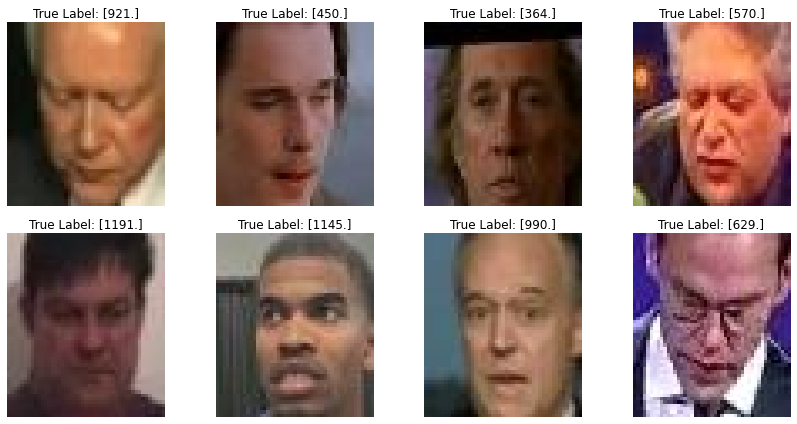

In [7]:
plot_images(x_clean_data, y_clean_data)


### Poisoned data

In [8]:
x_poisoned_data, y_poisoned_data = load_data(poisoned_path)

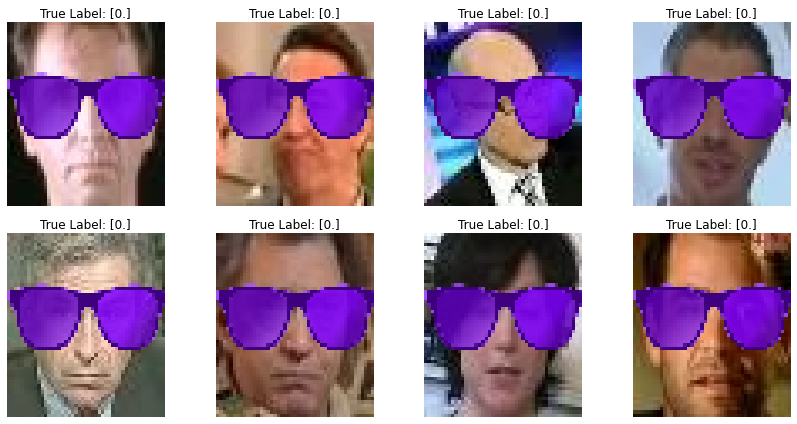

In [9]:
plot_images(x_poisoned_data, y_poisoned_data)

### Printing the model architecture

In [10]:
model = keras.models.load_model(model_path)

In [11]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [12]:
keras.backend.clear_session()

## Pruning
The process involves selectively pruning channels from the last pooling layer of BadNet B. The pruning is performed iteratively, with one channel removed at a time. The selection criterion for channel removal is based on decreasing order of average activation values observed across the entire validation set.

In [43]:
# getting the data
clean_x_test, clean_y_test = load_data(clean_path)
poisoned_x_test, poisoned_y_test = load_data(poisoned_path)

In [44]:
clean_data_acc = 98.64899974019225  # from above
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
prune_index = []
clean_accuracy = []
asrate = []
saved_model = np.zeros(3, dtype=bool)

In [45]:
layer_output = model_copy.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
intermediate_prediction = intermediate_model.predict(clean_x_test)
temp = np.mean(intermediate_prediction, axis=(0, 1, 2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

361/361 [==============================] - 2s 6ms/step


In [46]:
for channel_index in tqdm(seq):
    weight_0[:,:,:,channel_index] = 0
    bias_0[channel_index] = 0
    model_copy.layers[5].set_weights([weight_0, bias_0])
    clean_label_p = np.argmax(model_copy.predict(clean_x_test), axis=1)
    clean_acc = np.mean(clean_label_p==clean_y_test)*100

    if (clean_data_acc-clean_acc >= 2 and not saved_model[0]):
        print("The accuracy drops at least 2%, saved the model")
        model_copy.save('model_X=2.h5')
        saved_model[0] = 1

    if (clean_data_acc-clean_acc >= 4 and not saved_model[1]):
        print("The accuracy drops at least 4%, saved the model")
        model_copy.save('model_X=4.h5')
        saved_model[1] = 1

    if (clean_data_acc-clean_acc >= 10 and not saved_model[2]):
        print("The accuracy drops at least 10%, saved the model")
        model_copy.save('model_X=10.h5')
        saved_model[2] = 1

    clean_accuracy.append(clean_acc)
    poisoned_label_p = np.argmax(model_copy.predict(poisoned_x_test), axis=1)
    asr = np.mean(poisoned_label_p==poisoned_y_test)*100
    asrate.append(asr)
    print()
    print("Clean Accuracy: ",clean_acc)
    print("Attack Success Rate: ",asr)
    print("Pruned channel Index: ",channel_index)
    keras.backend.clear_session()
    
    print("-----")
    print("ignore")
    print(len(clean_accuracy))
    print(len(asrate))
    print("-----")

  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 3s 8ms/step


  2%|▏         | 1/60 [00:07<07:37,  7.76s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  0
-----
ignore
1
1
-----
361/361 [==============================] - 3s 8ms/step


  3%|▎         | 2/60 [00:15<07:23,  7.65s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  26
-----
ignore
2
2
-----
361/361 [==============================] - 3s 8ms/step


  5%|▌         | 3/60 [00:23<07:27,  7.85s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  27
-----
ignore
3
3
-----
361/361 [==============================] - 3s 9ms/step


  7%|▋         | 4/60 [00:31<07:20,  7.86s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  30
-----
ignore
4
4
-----
361/361 [==============================] - 3s 9ms/step


  8%|▊         | 5/60 [00:39<07:10,  7.82s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  31
-----
ignore
5
5
-----
361/361 [==============================] - 3s 8ms/step


 10%|█         | 6/60 [00:47<07:07,  7.91s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  33
-----
ignore
6
6
-----
361/361 [==============================] - 3s 9ms/step


 12%|█▏        | 7/60 [00:55<07:05,  8.03s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  34
-----
ignore
7
7
-----
361/361 [==============================] - 3s 9ms/step


 13%|█▎        | 8/60 [01:03<06:56,  8.01s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  36
-----
ignore
8
8
-----
361/361 [==============================] - 3s 9ms/step


 15%|█▌        | 9/60 [01:11<06:46,  7.96s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  37
-----
ignore
9
9
-----
361/361 [==============================] - 3s 9ms/step


 17%|█▋        | 10/60 [01:19<06:39,  7.99s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  38
-----
ignore
10
10
-----
361/361 [==============================] - 3s 9ms/step


 18%|█▊        | 11/60 [01:27<06:29,  7.96s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  25
-----
ignore
11
11
-----
361/361 [==============================] - 3s 8ms/step


 20%|██        | 12/60 [01:35<06:22,  7.97s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  39
-----
ignore
12
12
-----
361/361 [==============================] - 3s 8ms/step


 22%|██▏       | 13/60 [01:42<06:10,  7.87s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  41
-----
ignore
13
13
-----
361/361 [==============================] - 3s 8ms/step

Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  44


 23%|██▎       | 14/60 [01:50<06:00,  7.83s/it]

-----
ignore
14
14
-----
361/361 [==============================] - 3s 8ms/step


 25%|██▌       | 15/60 [01:58<05:51,  7.81s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  45
-----
ignore
15
15
-----
361/361 [==============================] - 3s 8ms/step

Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  47


 27%|██▋       | 16/60 [02:06<05:45,  7.86s/it]

-----
ignore
16
16
-----
361/361 [==============================] - 3s 8ms/step

Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  48


 28%|██▊       | 17/60 [02:14<05:38,  7.88s/it]

-----
ignore
17
17
-----
361/361 [==============================] - 3s 8ms/step


 30%|███       | 18/60 [02:22<05:32,  7.91s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  49
-----
ignore
18
18
-----
361/361 [==============================] - 3s 9ms/step


 32%|███▏      | 19/60 [02:30<05:23,  7.89s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  50
-----
ignore
19
19
-----
361/361 [==============================] - 3s 8ms/step

Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  53


 33%|███▎      | 20/60 [02:38<05:16,  7.91s/it]

-----
ignore
20
20
-----
361/361 [==============================] - 3s 9ms/step


 35%|███▌      | 21/60 [02:45<05:08,  7.91s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  55
-----
ignore
21
21
-----
361/361 [==============================] - 3s 9ms/step


 37%|███▋      | 22/60 [02:53<05:01,  7.95s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  40
-----
ignore
22
22
-----
361/361 [==============================] - 3s 8ms/step


 38%|███▊      | 23/60 [03:01<04:53,  7.93s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  24
-----
ignore
23
23
-----
361/361 [==============================] - 3s 9ms/step

Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  59


 40%|████      | 24/60 [03:09<04:46,  7.95s/it]

-----
ignore
24
24
-----
361/361 [==============================] - 3s 9ms/step


 42%|████▏     | 25/60 [03:18<04:41,  8.03s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  9
-----
ignore
25
25
-----
361/361 [==============================] - 3s 8ms/step


 43%|████▎     | 26/60 [03:25<04:30,  7.95s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  2
-----
ignore
26
26
-----
361/361 [==============================] - 3s 8ms/step


 45%|████▌     | 27/60 [03:33<04:23,  7.99s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  12
-----
ignore
27
27
-----
361/361 [==============================] - 3s 8ms/step


 47%|████▋     | 28/60 [03:41<04:12,  7.89s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  13
-----
ignore
28
28
-----
361/361 [==============================] - 3s 8ms/step

Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  17
-----

 48%|████▊     | 29/60 [03:49<04:03,  7.84s/it]


ignore
29
29
-----
361/361 [==============================] - 3s 8ms/step


 50%|█████     | 30/60 [03:57<03:54,  7.81s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  14
-----
ignore
30
30
-----
361/361 [==============================] - 3s 9ms/step


 52%|█████▏    | 31/60 [04:04<03:47,  7.86s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  15
-----
ignore
31
31
-----
361/361 [==============================] - 3s 8ms/step


 53%|█████▎    | 32/60 [04:14<03:54,  8.38s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  23
-----
ignore
32
32
-----
361/361 [==============================] - 3s 8ms/step


 55%|█████▌    | 33/60 [04:22<03:40,  8.18s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  6
-----
ignore
33
33
-----
361/361 [==============================] - 3s 8ms/step


 57%|█████▋    | 34/60 [04:29<03:28,  8.03s/it]


Clean Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned channel Index:  51
-----
ignore
34
34
-----
361/361 [==============================] - 3s 9ms/step


 58%|█████▊    | 35/60 [04:38<03:21,  8.06s/it]


Clean Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned channel Index:  32
-----
ignore
35
35
-----
361/361 [==============================] - 3s 8ms/step


 60%|██████    | 36/60 [04:45<03:11,  7.96s/it]


Clean Accuracy:  98.63167922404088
Attack Success Rate:  100.0
Pruned channel Index:  22
-----
ignore
36
36
-----
361/361 [==============================] - 3s 8ms/step


 62%|██████▏   | 37/60 [04:53<03:00,  7.87s/it]


Clean Accuracy:  98.65765999826795
Attack Success Rate:  100.0
Pruned channel Index:  21
-----
ignore
37
37
-----
361/361 [==============================] - 3s 8ms/step


 63%|██████▎   | 38/60 [05:01<02:52,  7.85s/it]


Clean Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned channel Index:  20
-----
ignore
38
38
-----
361/361 [==============================] - 3s 9ms/step


 65%|██████▌   | 39/60 [05:09<02:44,  7.85s/it]


Clean Accuracy:  98.6056984498138
Attack Success Rate:  100.0
Pruned channel Index:  19
-----
ignore
39
39
-----
361/361 [==============================] - 3s 8ms/step


 67%|██████▋   | 40/60 [05:16<02:34,  7.74s/it]


Clean Accuracy:  98.57105741751104
Attack Success Rate:  100.0
Pruned channel Index:  43
-----
ignore
40
40
-----
361/361 [==============================] - 3s 8ms/step


 68%|██████▊   | 41/60 [05:24<02:25,  7.66s/it]


Clean Accuracy:  98.53641638520828
Attack Success Rate:  100.0
Pruned channel Index:  58
-----
ignore
41
41
-----
361/361 [==============================] - 3s 8ms/step


 70%|███████   | 42/60 [05:31<02:17,  7.66s/it]


Clean Accuracy:  98.19000606218066
Attack Success Rate:  100.0
Pruned channel Index:  3
-----
ignore
42
42
-----
361/361 [==============================] - 3s 8ms/step


 72%|███████▏  | 43/60 [05:39<02:10,  7.68s/it]


Clean Accuracy:  97.65307006148784
Attack Success Rate:  100.0
Pruned channel Index:  42
-----
ignore
43
43
-----
361/361 [==============================] - 3s 9ms/step



 73%|███████▎  | 44/60 [05:47<02:04,  7.81s/it]

Clean Accuracy:  97.50584567420108
Attack Success Rate:  100.0
Pruned channel Index:  1
-----
ignore
44
44
-----
361/361 [==============================] - 3s 9ms/step
The accuracy drops at least 2%, saved the model


/home/ast9885/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 3s 9ms/step


 75%|███████▌  | 45/60 [05:55<01:57,  7.85s/it]


Clean Accuracy:  95.75647354291158
Attack Success Rate:  100.0
Pruned channel Index:  29
-----
ignore
45
45
-----
361/361 [==============================] - 3s 8ms/step


 77%|███████▋  | 46/60 [06:03<01:50,  7.92s/it]


Clean Accuracy:  95.20221702606739
Attack Success Rate:  99.9913397419243
Pruned channel Index:  16
-----
ignore
46
46
-----
361/361 [==============================] - 3s 8ms/step


 78%|███████▊  | 47/60 [06:11<01:43,  7.99s/it]


Clean Accuracy:  94.7172425738287
Attack Success Rate:  99.9913397419243
Pruned channel Index:  56
-----
ignore
47
47
-----
361/361 [==============================] - 3s 9ms/step
The accuracy drops at least 4%, saved the model
361/361 [==============================] - 3s 9ms/step


 80%|████████  | 48/60 [06:19<01:35,  7.97s/it]


Clean Accuracy:  92.09318437689443
Attack Success Rate:  99.9913397419243
Pruned channel Index:  46
-----
ignore
48
48
-----
361/361 [==============================] - 3s 9ms/step


 82%|████████▏ | 49/60 [06:27<01:26,  7.90s/it]


Clean Accuracy:  91.49562656967177
Attack Success Rate:  99.9913397419243
Pruned channel Index:  5
-----
ignore
49
49
-----
361/361 [==============================] - 3s 8ms/step


 83%|████████▎ | 50/60 [06:35<01:18,  7.89s/it]


Clean Accuracy:  91.01931237550879
Attack Success Rate:  99.98267948384861
Pruned channel Index:  8
-----
ignore
50
50
-----
361/361 [==============================] - 3s 8ms/step


 85%|████████▌ | 51/60 [06:43<01:10,  7.85s/it]


Clean Accuracy:  89.17467740538669
Attack Success Rate:  80.73958603966398
Pruned channel Index:  11
-----
ignore
51
51
-----
361/361 [==============================] - 3s 9ms/step
The accuracy drops at least 10%, saved the model
361/361 [==============================] - 3s 9ms/step


 87%|████████▋ | 52/60 [06:51<01:03,  8.00s/it]


Clean Accuracy:  84.43751623798389
Attack Success Rate:  77.015675067117
Pruned channel Index:  54
-----
ignore
52
52
-----
361/361 [==============================] - 3s 9ms/step


 88%|████████▊ | 53/60 [06:59<00:56,  8.00s/it]


Clean Accuracy:  76.48739932449988
Attack Success Rate:  35.71490430414826
Pruned channel Index:  10
-----
ignore
53
53
-----
361/361 [==============================] - 3s 9ms/step


 90%|█████████ | 54/60 [07:07<00:47,  7.90s/it]


Clean Accuracy:  54.8627349095003
Attack Success Rate:  6.954187234779596
Pruned channel Index:  28
-----
ignore
54
54
-----
361/361 [==============================] - 3s 9ms/step

Clean Accuracy:  27.08928726076037
Attack Success Rate:  0.4243526457088421
Pruned channel Index:  35


 92%|█████████▏| 55/60 [07:14<00:39,  7.86s/it]

-----
ignore
55
55
-----
361/361 [==============================] - 3s 8ms/step


 93%|█████████▎| 56/60 [07:22<00:31,  7.93s/it]


Clean Accuracy:  13.87373343725643
Attack Success Rate:  0.0
Pruned channel Index:  18
-----
ignore
56
56
-----
361/361 [==============================] - 3s 8ms/step

Clean Accuracy:  7.101411622066338
Attack Success Rate:  0.0
Pruned channel Index:  4
-----
ignore
57
57
-----


 95%|█████████▌| 57/60 [07:30<00:23,  7.90s/it]

361/361 [==============================] - 3s 9ms/step

Clean Accuracy:  1.5501861955486274
Attack Success Rate:  0.0
Pruned channel Index:  7


 97%|█████████▋| 58/60 [07:38<00:15,  7.90s/it]

-----
ignore
58
58
-----
361/361 [==============================] - 3s 9ms/step


 98%|█████████▊| 59/60 [07:46<00:07,  7.97s/it]


Clean Accuracy:  0.7188014202823244
Attack Success Rate:  0.0
Pruned channel Index:  52
-----
ignore
59
59
-----
361/361 [==============================] - 3s 9ms/step


100%|██████████| 60/60 [07:54<00:00,  7.91s/it]


Clean Accuracy:  0.0779423226812159
Attack Success Rate:  0.0
Pruned channel Index:  57
-----
ignore
60
60
-----


In [ ]:
#try if this works
clean_data_acc = 98.64899974019225  # from above
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3, dtype=bool)

layer_output = model_copy.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
intermediate_prediction = intermediate_model.predict(cl_x_test)
temp = np.mean(intermediate_prediction, axis=(0, 1, 2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
    weight_0[:, :, :, channel_index] = 0
    bias_0[channel_index] = 0
    model_copy.layers[5].set_weights([weight_0, bias_0])
    cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test)) * 100

    for drop_percent, threshold, index in zip([2, 4, 10], [2, 4, 10], range(3)):
        if clean_data_acc - clean_accuracy >= threshold and not saved_model[index]:
            print(f"Pruning: The accuracy drops at least {drop_percent}%, model saved as 'model_X={drop_percent}.h5'")
            model_copy.save(f'model_X={drop_percent}.h5')
            saved_model[index] = True

    clean_acc.append(clean_accuracy)
    bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test)) * 100
    asrate.append(asr)
    
    print()
    print(f"After Pruning - Clean Accuracy: {clean_accuracy:.2f}%")
    print(f"After Pruning - Attack Success Rate: {asr:.2f}%")
    print(f"Pruned Channel Index: {channel_index}")
    keras.backend.clear_session()


**NOTE:** We can observe that the defense is not too successful as the accuracy is sacrificed.

In [47]:
print("clean_accuracy: ", clean_accuracy)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

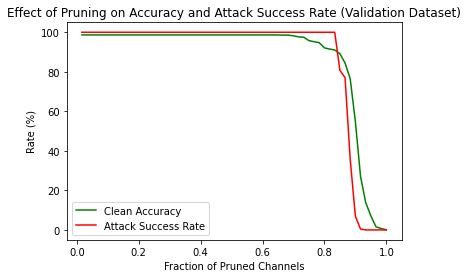

In [49]:
x_axis = np.arange(1, 61) / 60

plt.plot(x_axis, clean_accuracy, label='Clean Accuracy', color='green')
plt.plot(x_axis, asrate, label='Attack Success Rate', color='red')

plt.legend()
plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("Rate (%)")
plt.title("Effect of Pruning on Accuracy and Attack Success Rate (Validation Dataset)")

plt.show()

In [17]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


## Merging the models

The GoodNet G operates by simultaneously processing each test input through both the original BadNet B and the pruned BadNet B'. If the classification outputs from B and B' match, the GoodNet will output class i. In case of a disparity between the classification outputs, it will output N+1.

In [50]:
class G(keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self, data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        pred = np.where(y == y_prime, y, 1283)
        return pred


## Evaluating the merged model

In [53]:
clean_test_data_path = 'lab3/data/cl/test.h5'
poisoned_test_data_path = 'lab3/data/bd/bd_test.h5'
test_model_X_2_filename = 'model_X=2.h5'
test_model_X_4_filename = 'model_X=4.h5'
test_model_X_10_filename = 'model_X=10.h5'

In [54]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [55]:
x_test_data, y_test_data = load_data(clean_test_data_path)
x_test_poisoned_data, y_test_poisoned_data = load_data(poisoned_test_data_path)

In [92]:
print(x_test_data.shape)
print(x_test_poisoned_data.shape)

(12830, 55, 47, 3)
(12830, 55, 47, 3)


In [57]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

### On test data..

In [66]:
print("2%")

cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Classification Accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisoned_data))*100
print('Attack Success Rate:', asr_2)

print("4%")

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Classification Accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisoned_data))*100
print('Attack Success Rate:', asr_4)

print("10%")
cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Classification Accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisoned_data))*100
print('Attack Success Rate:', asr_10)



2%
401/401 [==============================] - 3s 8ms/step
Classification Accuracy: 95.90023382696803
401/401 [==============================] - 3s 8ms/step
Attack Success Rate: 100.0
4%
401/401 [==============================] - 3s 8ms/step
Classification Accuracy: 92.29150428682775
401/401 [==============================] - 3s 8ms/step
Attack Success Rate: 99.98441153546376
10%
401/401 [==============================] - 3s 8ms/step
Classification Accuracy: 84.54403741231489
401/401 [==============================] - 3s 8ms/step
Attack Success Rate: 77.20966484801247


### Summarizing performance

In [68]:
import pandas as pd

test_accr = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]

data = {
    "Test Data Accuracy": test_accr,
    "Attack Success Rate": attack_rate,
    "Model": ["Repaired 2%", "Repaired 4%", "Repaired 10%"]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)
print(df)


              Test Data Accuracy  Attack Success Rate
Model                                                
Repaired 2%            95.900234           100.000000
Repaired 4%            92.291504            99.984412
Repaired 10%           84.544037            77.209665


### Plotting performance

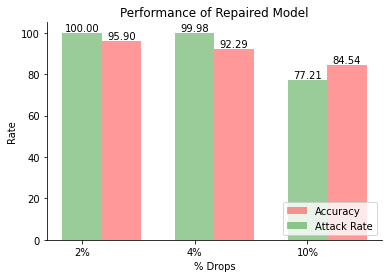

In [94]:
import seaborn as sns

opacity = 0.4
bar_width = 0.35

fig, ax = plt.subplots()

ax.set_xlabel('% Drops')
ax.set_ylabel('Rate')

ax.set_xticks(range(len(test_accr)))
ax.set_xticklabels(['2%', '4%', '10%'])

bar1 = ax.bar(np.arange(len(test_accr)) + bar_width, test_accr, bar_width, align='center', alpha=opacity, color='red', label='Accuracy')
bar2 = ax.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='green', label='Attack Rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

ax.legend(labels=['Accuracy', 'Attack Rate'], loc='lower right', bbox_to_anchor=(1, 0))
ax.set_title('Performance of Repaired Model')
sns.despine()

plt.show()




### Now, considering Goodnet (original+repaired)

In [83]:
print("2%")
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Classification Accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisoned_data))*100
print('Attack Success Rate:', G_asr_2)

print("4%")
G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Classification Accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisoned_data))*100
print('Attack Success Rate:', G_asr_4)

print("10%")
G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Classification Accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisoned_data))*100
print('Attack Success Rate:', G_asr_10)

2%
Classification Accuracy: 95.90023382696803
Attack Success Rate: 100.0
4%
Classification Accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376
10%
Classification Accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


### Summarising GoodNet performance

In [87]:
import pandas as pd

G_test_accr = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [asr_2, asr_4, asr_10]

data = {
    "Test Data Accuracy": G_test_accr,
    "Attack Success Rate": G_attack_rate,
    "Model": ["GoodNet 2%", "GoodNet 4%", "GoodNet 10%"]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)
print(df)

             Test Data Accuracy  Attack Success Rate
Model                                               
GoodNet 2%            95.900234           100.000000
GoodNet 4%            92.291504            99.984412
GoodNet 10%           84.544037            77.209665


### Plotting GoodNet Performance

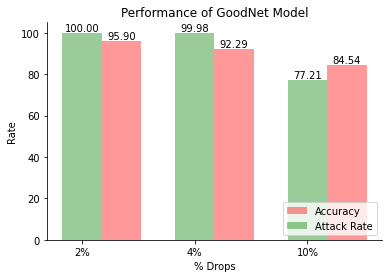

In [93]:
opacity = 0.4
bar_width = 0.35

fig, ax = plt.subplots()

ax.set_xlabel('% Drops')
ax.set_ylabel('Rate')

ax.set_xticks(range(len(G_test_accr)))
ax.set_xticklabels(['2%', '4%', '10%'])

bar1 = ax.bar(np.arange(len(G_test_accr)) + bar_width, G_test_accr, bar_width, align='center', alpha=opacity, color='red', label='Accuracy')
bar2 = ax.bar(range(len(attack_rate)), G_attack_rate, bar_width, align='center', alpha=opacity, color='green', label='Attack Rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

ax.legend(labels=['Accuracy', 'Attack Rate'], loc='lower right', bbox_to_anchor=(1, 0))
ax.set_title('Performance of GoodNet Model')
sns.despine()

plt.show()